In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                                          for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

In [3]:
image_datasets

{'train': <torchvision.datasets.folder.ImageFolder at 0x7f6ec10825f8>,
 'val': <torchvision.datasets.folder.ImageFolder at 0x7f6ebc6a3240>}

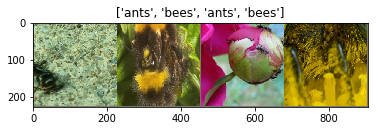

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
        
            running_loss = 0.
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())

                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time()- since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [5]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

if use_gpu:
    model_ft = model_ft.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5334 Acc: 0.7500
val Loss: 0.1938 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4826 Acc: 0.7869
val Loss: 0.2585 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5141 Acc: 0.7869
val Loss: 0.2280 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.6073 Acc: 0.7787
val Loss: 0.4087 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.6735 Acc: 0.7869
val Loss: 0.4019 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4009 Acc: 0.8525
val Loss: 0.3519 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4444 Acc: 0.8156
val Loss: 0.2981 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.2719 Acc: 0.8893
val Loss: 0.2251 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2877 Acc: 0.8934
val Loss: 0.2119 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3039 Acc: 0.8566
val Loss: 0.2211 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3157 Acc: 0.8730
val Loss: 0.1996 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2768 Acc: 0.8770
val Loss: 0.2118 Acc: 0.9216

Ep

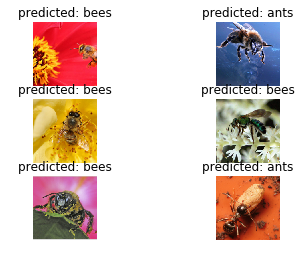

In [21]:
visualize_model(model_ft)

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6698 Acc: 0.6148
val Loss: 0.2386 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5971 Acc: 0.7418
val Loss: 0.3597 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4832 Acc: 0.7910
val Loss: 0.2188 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3745 Acc: 0.8238
val Loss: 0.2136 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3742 Acc: 0.8402
val Loss: 0.1915 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4593 Acc: 0.7910
val Loss: 0.1620 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.5169 Acc: 0.7910
val Loss: 0.1594 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3268 Acc: 0.8525
val Loss: 0.1758 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3314 Acc: 0.8648
val Loss: 0.1762 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3458 Acc: 0.8484
val Loss: 0.1845 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3130 Acc: 0.8566
val Loss: 0.1653 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3707 Acc: 0.8443
val Loss: 0.1648 Acc: 0.9477

Ep

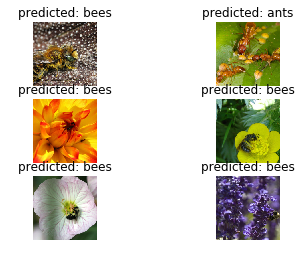

In [27]:
visualize_model(model_conv)

plt.ioff()
plt.show()